In [22]:
# %matplotlib inline
#
import astra
import matplotlib.pyplot as plt
import numpy as np
#
import vtk
from vtk.util import numpy_support
#
# Custom routines
import routines
#
from importlib import reload
routines = reload(routines)

In [2]:
help(routines)

Help on module routines:

NAME
    routines

FUNCTIONS
    get_metal_volume(vol_spacing, xyz_bounds, polydata_envelop, list_polydata_cores, list_transform_cores)
        Create a voxelized image of the metal volume defined by the STL surface mesh.
        xyz_bounds: [xmin, xmax, ymin, ymax, zmin, zmax]

FILE
    /home/julianb/dev/rxtools/OptViewsWallThickness/routines.py




#### notebook optimization views for inspection wall thickness, from thesis C. FRAGNAUD

DONE: run astra on public blade 
TODO: separate parts blades   (by 08/11)
TODO: implement pdvc as in thesis cedric (by 11/11)
TODO: implement approach 1 (maybe by 11/11, approach 1 or 2)
TODO: implement approach 2 (tbd)

In [ ]:
envelope_filename_stl="./Blade0.stl"
cores=["./Core1.stl", "./Core2.stl"]
#
# Voxelization
voxel_pitch_mm = 0.5   # voxel edge length in mm
#
# Material / thickness map scale (line integrals in "cm" if you want physical units)
mu_cm_inv = 1.0

# Scan geometry (cone-beam)
n_projections = 360         # number of views 0..360 deg
SOD_mm = 700.0              # Source-to-Object (isocenter) distance in mm
SDD_mm = 1200.0             # Source-to-Detector distance in mm
det_pixel_mm = 3.          # detector pixel pitch in mm (u and v)


# Detector sampling (rows=vertical ~ z, cols=horizontal ~ x)
# Tip: start with ~object size / det_pixel_mm, then adjust
det_col_count = None        # if None, will auto-set ~1.2*volume size in vox
det_row_count = None

########################
### PARAMETRIC MODEL ###
########################
#
# Projection geometry parameters
params_proj = {
    "rotAngles": [0.0, 0.0, 0.0],
    "shiftVol": [0.0, 0.0, 0.0]
}

# geometry deformation parameters
params_def = {
    "core1": {
        "rotAngles": [0.0, 0.0, 0.0],
        "shiftVol": [0.0, 0.0, 0.0],
    },
    "core2": {
        "rotAngles": [0.0, 0.0, 0.0],
        "shiftVol": [0.0, 0.0, 0.0],
    },
}


In [13]:
# ---- 1) Read STL with VTK ----
reader = vtk.vtkSTLReader()
reader.SetFileName(envelope_filename_stl)
reader.Update()
poly_envelope = reader.GetOutput()
#
if poly_envelope is None or poly_envelope.GetNumberOfPoints() == 0:
    raise RuntimeError("Failed to load STL or it contains no points.")

In [23]:
# ========= 2) Build target image grid from bounds =========
xmin, xmax, ymin, ymax, zmin, zmax = poly_envelope.GetBounds()

sx = sy = sz = float(voxel_pitch_mm)
"""
nx = int(np.ceil((xmax - xmin) / sx))
ny = int(np.ceil((ymax - ymin) / sy))
nz = int(np.ceil((zmax - zmin) / sz))
if nx <= 0 or ny <= 0 or nz <= 0:
    raise RuntimeError("Degenerate bounds; check STL units or geometry.")
"""

# VTK uses point dims = cell dims + 1
#dims = (nx + 1, ny + 1, nz + 1)

#volume = routines.get_metal_volume(vol_spacing=[sx, sy, sz], xyz_min=[xmin, ymin, zmin],  polydata_envelop=poly_envelope,list_polydata_cores=[], list_transform_cores=[])
volume = routines.get_metal_volume( vol_spacing=[sx, sy, sz], xyz_bounds=[xmin, xmax, ymin, ymax, zmin, zmax],  polydata_envelop=poly_envelope,list_polydata_cores=[], list_transform_cores=[], fill_in_value=mu_cm_inv)
"""
img = vtk.vtkImageData()
img.SetOrigin(xmin, ymin, zmin)
img.SetSpacing(sx, sy, sz)
img.SetDimensions(*dims)
img.AllocateScalars(vtk.VTK_FLOAT, 1)

# Fill with mu; we will zero outside using the stencil
img_np = numpy_support.vtk_to_numpy(img.GetPointData().GetScalars())
img_np.fill(mu_cm_inv)
"""

'\nimg = vtk.vtkImageData()\nimg.SetOrigin(xmin, ymin, zmin)\nimg.SetSpacing(sx, sy, sz)\nimg.SetDimensions(*dims)\nimg.AllocateScalars(vtk.VTK_FLOAT, 1)\n\n# Fill with mu; we will zero outside using the stencil\nimg_np = numpy_support.vtk_to_numpy(img.GetPointData().GetScalars())\nimg_np.fill(mu_cm_inv)\n'

In [ ]:
"""
# ========= 3) PolyData -> Image stencil, apply to image =========
poly2stencil = vtk.vtkPolyDataToImageStencil()
poly2stencil.SetInputData(poly_envelope)
poly2stencil.SetOutputOrigin(img.GetOrigin())
poly2stencil.SetOutputSpacing(img.GetSpacing())
extent = (0, dims[0]-1, 0, dims[1]-1, 0, dims[2]-1)
poly2stencil.SetOutputWholeExtent(*extent)
poly2stencil.Update()
#
stenciler = vtk.vtkImageStencil()
stenciler.SetInputData(img)
stenciler.SetStencilConnection(poly2stencil.GetOutputPort())
stenciler.SetBackgroundValue(0.0)  # everything *outside* STL -> 0 attenuation
stenciler.ReverseStencilOff()
stenciler.Update()
#
voxel_img = stenciler.GetOutput()
"""

In [ ]:
"""
# ========= 4) VTK image -> NumPy volume (z, y, x) =========
vol_scalars = voxel_img.GetPointData().GetScalars()
vol_np_flat = numpy_support.vtk_to_numpy(vol_scalars).astype(np.float32)

# reshape point grid then drop last index in each dim to get cell-centered voxels
nzp, nyp, nxp = dims[2], dims[1], dims[0]
vol_points = vol_np_flat.reshape((nzp, nyp, nxp))  # (z, y, x) order
volume = vol_points[:nz, :ny, :nx]                 # (z, y, x), float32
"""

In [24]:
# ========= 5) ASTRA volume geometry =========
print(volume.shape)
nz_v, ny_v, nx_v = volume.shape
vol_geom = astra.create_vol_geom(ny_v, nx_v, nz_v )

(109, 336, 112)


In [25]:
# ========= 6) Cone-beam projection geometry via 'cone_vec' =========
# ASTRA coordinates: volume is centered around the origin by default.
# We will define a *circular* source trajectory around +z axis, isocenter at (0,0,0).
# All distances must be in *voxel units* so we divide mm by voxel_pitch_mm.

px = voxel_pitch_mm
SOD_vox = SOD_mm / px
SDD_vox = SDD_mm / px
du = det_pixel_mm / px   # detector column pixel size in voxel units
dv = det_pixel_mm / px   # detector row pixel size in voxel units

# Auto-detector size if not given: ~1.2x object span (magnified)
if det_col_count is None:
    det_col_count = int(np.ceil(1.2 * nx_v))
if det_row_count is None:
    det_row_count = int(np.ceil(1.2 * nz_v))

angles = np.linspace(0.0, 2*np.pi, n_projections, endpoint=False).astype(np.float32)

# For each angle theta:
#   source position s = (R * cosθ, R * sinθ, 0), with R = SOD_vox
#   detector center c = s + n * SDD_vox, where n points from source -> isocenter (i.e., -s/||s||)
#   detector basis vectors:
#       u (cols, "right") = (-sinθ, cosθ, 0) * du
#       v (rows, "up")    = (0, 0, 1) * dv
vectors = np.zeros((n_projections, 12), dtype=np.float32)
for i, th in enumerate(angles):
    # source on circle radius SOD
    sx = SOD_vox * np.cos(th)
    sy = SOD_vox * np.sin(th)
    sz = 0.0
    s = np.array([sx, sy, sz], dtype=np.float32)

    # detector normal (from source to isocenter)
    n = (-s) / np.linalg.norm(s)

    # detector center position
    c = s + n * SDD_vox

    # detector pixel basis (right, up)
    u = np.array([-np.sin(th),  np.cos(th), 0.0], dtype=np.float32) * du
    v = np.array([0.0, 0.0, 1.0], dtype=np.float32) * dv

    vectors[i, 0:3]   = s
    vectors[i, 3:6]   = c
    vectors[i, 6:9]   = u
    vectors[i, 9:12]  = v

proj_geom = astra.create_proj_geom('cone_vec', det_row_count, det_col_count, vectors)

In [26]:
# ========= 7) Forward projection (CUDA if available) =========
vol_id = astra.data3d.create('-vol', vol_geom, volume)
proj_id = astra.data3d.create('-proj3d', proj_geom)

cfg = astra.astra_dict('FP3D_CUDA')  # you do have the CUDA build
#cfg = astra.astra_dict('FP3D')  # you do have the CUDA build
cfg['VolumeDataId'] = vol_id
cfg['ProjectionDataId'] = proj_id

alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id)

projections = astra.data3d.get(proj_id)  # shape: (n_views, det_rows, det_cols)

In [27]:
# ========= 8) Cleanup =========
astra.algorithm.delete(alg_id)
astra.data3d.delete(proj_id)
astra.data3d.delete(vol_id)

print("Volume (z,y,x):", volume.shape)
print("Projections (views, rows, cols):", projections.shape)

Volume (z,y,x): (109, 336, 112)
Projections (views, rows, cols): (131, 360, 135)


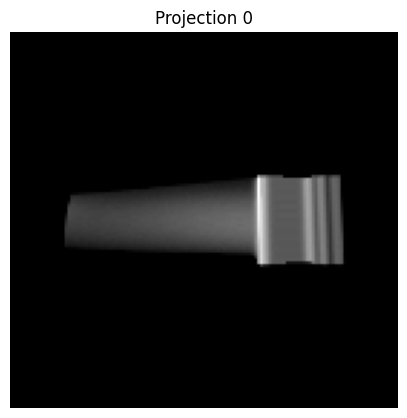

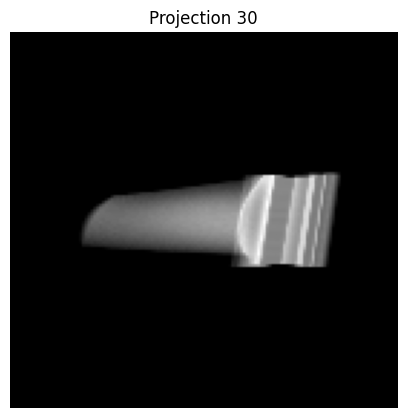

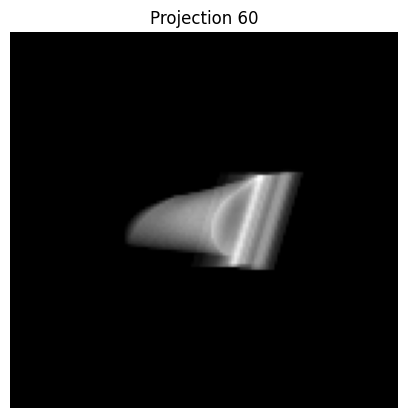

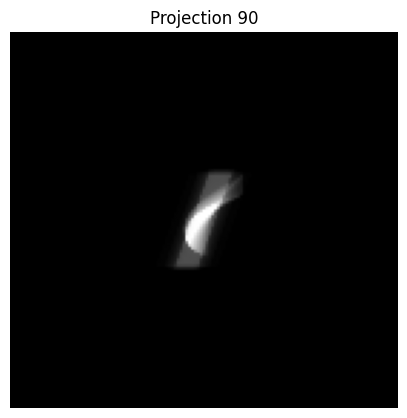

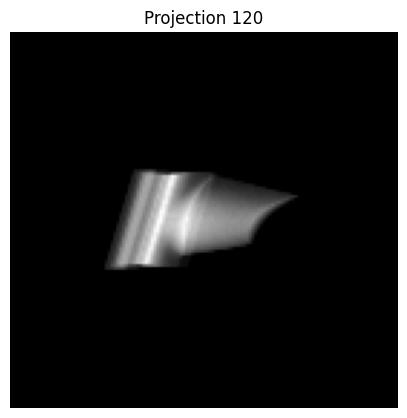

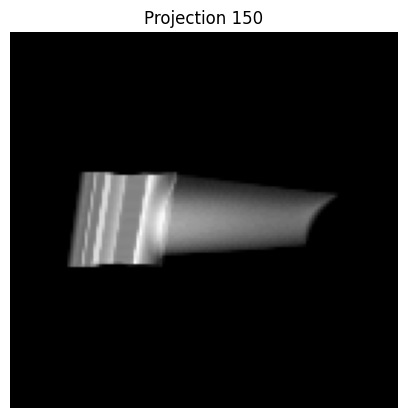

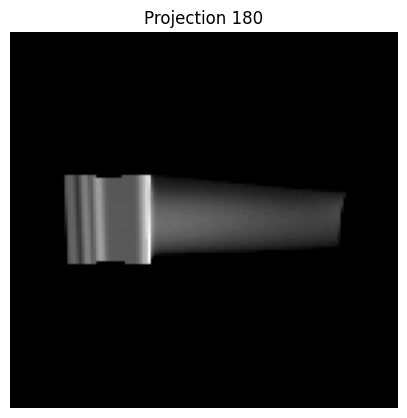

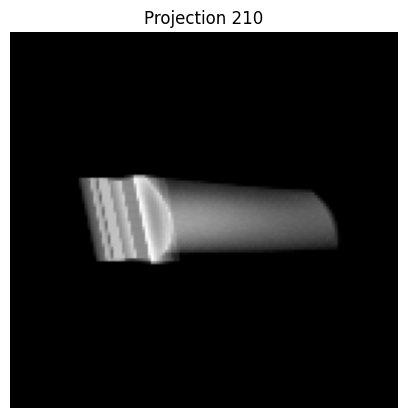

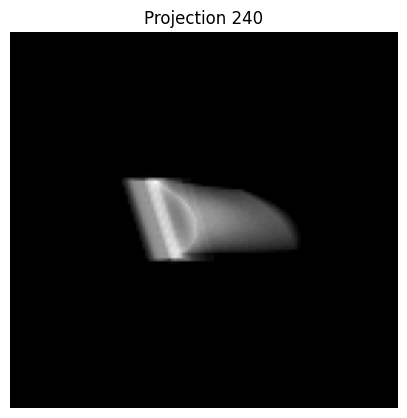

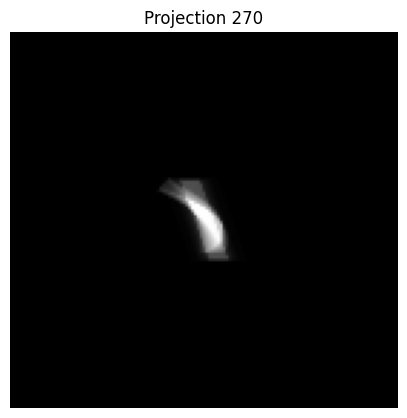

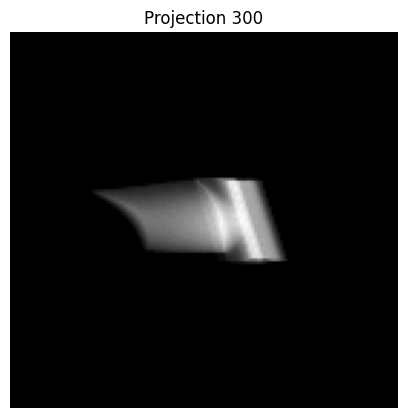

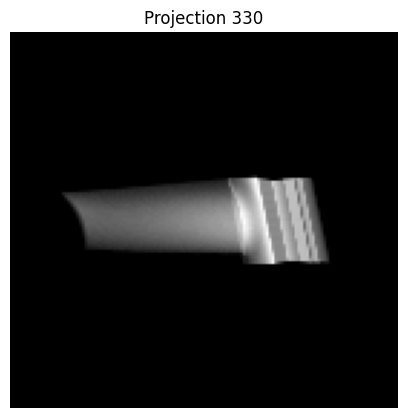

In [28]:
# preview:
# import matplotlib.pyplot as plt
for idx in range(0,n_projections,30):
    plt.figure(figsize=(5, 5))
    plt.imshow(projections[:,idx,:], cmap='gray')
    plt.axis('off')
    plt.title(f'Projection {idx}')
    plt.show()